In [49]:
import pandas as pd
import numpy as np

import scipy.sparse
import sklearn.feature_extraction

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm
import platform

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

import os

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### В матрице Main table всего 3 столбца, которые глобально характеризуют хэдэр

In [50]:
from logParser import ParseLogsFromFolder

main_data, values_data, order_data = ParseLogsFromFolder('Logs/', 0, 10, only_order=False)

main = pd.DataFrame(main_data)
#del(main_data)
print('Shape: ' + str(main.shape))
main.head()

  6%|▌         | 7/127 [00:04<01:14,  1.62it/s]


Shape: (289269, 3)


,User_Agent,id,ip
0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1485900038,95.181.252.91
1,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1485900047,40.77.167.74
2,Mozilla/5.0 (Linux; Android 4.4.2; Zera S Buil...,1485900079,31.148.3.19
3,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) G...,1485900103,188.162.183.66
4,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1485900105,37.144.52.103


In [51]:
print('Хэдэры первых 100 юзер-агентов составляют: {:.2%}'.format(
    main.User_Agent.value_counts()[:100].sum() / main.shape[0]))

print('Сохраним индексы хэдэров из топ-100')
main_top_100 = main[main.User_Agent.isin(main.User_Agent.value_counts()[:100].index)]
#del(main)

top_ua = main.User_Agent.value_counts()[:100].index.tolist()

Хэдэры первых 100 юзер-агентов составляют: 62.87%
Сохраним индексы хэдэров из топ-100


In [52]:
print('В order_data содержится информация о взаимном расположении ключей.')
print('Переведем ее к типу csr с помощью DictVectorizer')
orders_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_orders = orders_vectorizer.fit_transform(order_data).astype(np.int8)
#del(order_data)

В order_data содержится информация о взаимном расположении ключей.
Переведем ее к типу csr с помощью DictVectorizer


Можно было бы сразу создать нужную нам спарс матрицу с признаками попарным сравнением порядков. Однако в этом случае придется думать, как бы запомнить какой признак, что значит.

Так что я решил не думать и сделать по аналогии с вышеприведенным преобразованием: с созданием соответствующего списка словарей и DictVectorizer-a

In [53]:
from itertools import combinations

sparse_orders_top_100 = sparse_orders[main_top_100.index]

pairs_dict_list = []
for row_index in tqdm(range(sparse_orders_top_100.shape[0]), mininterval=2):
    pairs_dict = {}
    for pair_first, pair_second in combinations(sparse_orders_top_100[row_index].indices, 2):
        name_first = orders_vectorizer.feature_names_[pair_first]
        name_second = orders_vectorizer.feature_names_[pair_second]
        if sparse_orders_top_100[row_index, pair_first] < sparse_orders_top_100[row_index, pair_second]:
            pairs_dict['{0} < {1}'.format(name_first, name_second)] = 1
        else:
            pairs_dict['{0} < {1}'.format(name_second, name_first)] = 1
    pairs_dict_list.append(pairs_dict)

100%|██████████| 181851/181851 [02:58<00:00, 1020.24it/s]


In [54]:
sparse_orders_top_100.shape

(181851, 174)

In [55]:
main_top_100.shape

(181851, 3)

In [56]:
pairs_dict_list

[{'Accept < Accept-Encoding': 1,
  'Accept < Accept-Language': 1,
  'Accept < Referer': 1,
  'Accept-Encoding < Accept-Language': 1,
  'Referer < Accept-Encoding': 1,
  'Referer < Accept-Language': 1,
  'Upgrade-Insecure-Requests < Accept': 1,
  'Upgrade-Insecure-Requests < Accept-Encoding': 1,
  'Upgrade-Insecure-Requests < Accept-Language': 1,
  'Upgrade-Insecure-Requests < Referer': 1,
  'Upgrade-Insecure-Requests < User-Agent': 1,
  'User-Agent < Accept': 1,
  'User-Agent < Accept-Encoding': 1,
  'User-Agent < Accept-Language': 1,
  'User-Agent < Referer': 1},
 {'Accept < Accept-Encoding': 1,
  'Accept < From': 1,
  'Accept < Host': 1,
  'Accept < User-Agent': 1,
  'Accept-Encoding < From': 1,
  'Accept-Encoding < Host': 1,
  'Accept-Encoding < User-Agent': 1,
  'From < Host': 1,
  'From < User-Agent': 1,
  'Host < User-Agent': 1,
  'Pragma < Accept': 1,
  'Pragma < Accept-Encoding': 1,
  'Pragma < From': 1,
  'Pragma < Host': 1,
  'Pragma < User-Agent': 1},
 {'Accept < Accept-Enco

In [57]:
dummy_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_dummy = dummy_vectorizer.fit_transform(pairs_dict_list).astype(np.int8)
print(type(sparse_dummy))
print('Sparse dummy shape: \n{0}'.format(sparse_dummy.shape))
print('User Agent shape: \n{0}'.format(main_top_100.User_Agent.shape))

<class 'scipy.sparse.csr.csr_matrix'>
Sparse dummy shape: 
(181851, 1042)
User Agent shape: 
(181851,)


### Добавим значения ключей в модель

**Согласно README удалим неинформативные ключи**

In [3]:
exception_keys_set = {
    'User-Agent', 'Referer', 'Accept-Language', 'Host', 'X-Host','X-Forwarded-For',
    'Forwarded-For' ,'X-Network-Type','Cookie','X-Wap-Profile','X-Gateway','Ua-Cpu',
    'Rvbd-Csh','Dris-Orig-Src','X-Proxy-Id','Rvbd-Ssh','X-Requested-With'}

In [20]:
trimmed_values_data = list(values_data)

for row_index in tqdm(range(len(trimmed_values_data))):
    for key in exception_keys_set:
        trimmed_values_data[row_index].pop(key, -1)

100%|██████████| 289269/289269 [00:01<00:00, 217485.99it/s]


In [22]:
len(values_data)

289269

In [26]:
values_df = pd.DataFrame(trimmed_values_data)
values_df.head()

,Accept,Accept-Charset,Accept-Encoding,Authorization,Cache-Control,Cdn-Src-Ip,Charset,Chrome-Proxy,Chrome-Proxy-Accept-Transform,Client-Ip,Clientip,Cmd,Connection,Content-Length,Content-Range,Content-Type,Cookie2,Date,Device-Stock-Ua,Dnt,Drm-Version,F5-User-Ip,Forwarded,From,Giga-Transport,Http-Version,Http2-Settings,Https,If-Modified-Since,If-None-Match,Inter-Pro-Client,Keep-Alive,O2gw-Id,Origin,Oxpry-Connection,Ping-From,Ping-To,Pragma,Prefer,Proxy-Authorization,Proxy-Connection,Purpose,Q-Refer,Q-Ua,Range,Refresh-Cache,Rmch-Securitycookie,Save-Data,Scheme,Surrogate-Capability,Te,Upgrade,Upgrade-Insecure-Requests,Useragent,Version,Via,Wap-Connection,Wapconnection,Wshost,Wsip,X--------------,X-Accept-Encoding-Wn-Proxy-2,X-Agent-Client-Id,X-Agent-Session-Id,X-Att-Deviceid,X-Authenticated-User,X-B3-Flags,X-B3-Parentspanid,X-B3-Sampled,X-B3-Spanid,X-B3-Traceid,X-Bluecoat-Via,X-Busid,X-Categories,X-Chrome-Connected,X-Chrome-Uma-Enabled,X-Citrio-Timestamp,X-Client-Data,X-Cloud-Trace-Context,X-Compress,X-Content-Check,X-Content-Opt,X-D-Forwarder,X-Ebo-Ua,X-Fb-Http-Engine,X-Fb-Net-Hni,X-Fb-Sim-Hni,X-Featureversion,X-Firephp,X-Firephp-Version,X-Forwarded-Proto,X-Fuck,X-Getzip,X-Gfe-Ssl,X-Gfe-Tls-Channelid,X-Icap-Http-Stream,X-Icm,X-Imforwards,X-Iws-Via,X-Lb-Local,X-Liveinternetapplications,X-Loop-Control,X-Mcproxyfilter,X-Mfe-Response,X-Miorigin,X-Moz,X-Ms-Cookieuri-Requested,X-Msisdn,X-Mwg-Via,X-Newrelic-Id,X-Newrelic-Transaction,X-Nokia-Bearer,X-Nokia-Gateway-Id,X-Nokia-Maxdownlinkbitrate,X-Nokia-Maxuplinkbitrate,X-Nokia-Musicshop-Bearer,X-Nokia-Musicshop-Version,X-Ob,X-Office-Major-Version,X-Onv-Icap,X-Openfrequencylimit,X-Openshield,X-Opera-Id,X-Opera-Info,X-Operamini-Fb,X-Operamini-Features,X-Operamini-Phone,X-Operamini-Phone-Ua,X-Operamini-Route,X-Org-Request,X-Original-Url,X-P2p-Peerdist,X-P2p-Peerdistex,X-Pocket-Parser,X-Ps3-Browser,X-Psa-Client-Features,X-Psa-Client-Options,X-Psp-Browser,X-Psp-Productcode,X-Puffin-Ua,X-Purpose,X-Rbt-Optimized-By,X-Real-Ip,X-Requestfrom,X-Server-Ip,X-Time,X-Turbo-Compression,X-Turbo-Id,X-Ucbrowser-Device,X-Ucbrowser-Device-Ua,X-Ucbrowser-Ua,X-Up-Vfza-Id,X-User,X-Vermeer-Content-Type,X-Wap-Client-Ip,X-Wap-Profile-Diff,X-Wap-Proxy-Cookie,X-Wapipaddr,X-Wf-Max-Combined-Size,X-Wisp,X-Xorwarded-For,X-Xuthenticated-User,X-Yandex-Turbo,X-Youtube-Edu-Filter,X3,Xroxy-Connection
0,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*/*,NaN,"gzip, deflate",NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep-Alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bingbot(at)microsoft.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [27]:
print(values_df.shape)
for column in values_df.columns:
    print(column, values_df[column].unique().shape, values_df[column].dropna().shape)

(289269, 166)
Accept (255,) (275910,)
Accept-Charset (66,) (21277,)
Accept-Encoding (43,) (271181,)
Authorization (3,) (9,)
Cache-Control (76,) (27250,)
Cdn-Src-Ip (2,) (1,)
Charset (2,) (3,)
Chrome-Proxy (10,) (12,)
Chrome-Proxy-Accept-Transform (2,) (4,)
Client-Ip (8,) (9,)
Clientip (724,) (856,)
Cmd (43,) (42,)
Connection (15,) (233711,)
Content-Length (638,) (1587,)
Content-Range (2,) (12,)
Content-Type (15,) (2702,)
Cookie2 (4,) (22,)
Date (9,) (8,)
Device-Stock-Ua (579,) (1208,)
Dnt (3,) (16536,)
Drm-Version (4,) (9,)
F5-User-Ip (14,) (15,)
Forwarded (6248,) (7682,)
From (18,) (37298,)
Giga-Transport (50,) (49,)
Http-Version (2,) (2,)
Http2-Settings (2,) (2,)
Https (2,) (19,)
If-Modified-Since (10880,) (11255,)
If-None-Match (4,) (21,)
Inter-Pro-Client (3,) (8,)
Keep-Alive (6,) (836,)
O2gw-Id (4,) (3,)
Origin (8,) (176,)
Oxpry-Connection (2,) (3,)
Ping-From (45,) (46,)
Ping-To (37,) (46,)
Pragma (2,) (22310,)
Prefer (2,) (50,)
Proxy-Authorization (222,) (336,)
Proxy-Connection (5

Применим очень тупой отбор признаков:
- если определенный ключ появляется ну очень редко(например менее чем в 0.1% хэдэров, то мы считаем его неинформативным)
- если у определенного ключа почти все значения различны(например если отношение общего значений к числу уникальных очень мало(например меньше 2)

In [28]:
print(values_df.shape)
important_keys = []
for column in values_df.columns:
    not_null_count = values_df[column].dropna().shape[0]
    if not_null_count  >= values_df.shape[0] * 0.001:
        uniq_count = values_df[column].unique().shape[0]
        if not_null_count / uniq_count >= 2:
            print(column, uniq_count, not_null_count)
            important_keys.append(column)
' '.join(important_keys)

(289269, 166)
Accept 255 275910
Accept-Charset 66 21277
Accept-Encoding 43 271181
Cache-Control 76 27250
Connection 15 233711
Content-Length 638 1587
Content-Type 15 2702
Device-Stock-Ua 579 1208
Dnt 3 16536
From 18 37298
Keep-Alive 6 836
Pragma 2 22310
Proxy-Connection 5 346
Range 10 483
Save-Data 3 8824
Scheme 2 4849
Surrogate-Capability 74 317
Te 4 892
Upgrade-Insecure-Requests 2 111716
Via 1590 11229
X-Compress 5 1337
X-Forwarded-Proto 2 1395
X-Moz 2 1982
X-Operamini-Features 16 1317
X-Operamini-Phone 37 1317
X-Operamini-Phone-Ua 575 1309
X-Turbo-Compression 2 332
X-Yandex-Turbo 3 1434


'Accept Accept-Charset Accept-Encoding Cache-Control Connection Content-Length Content-Type Device-Stock-Ua Dnt From Keep-Alive Pragma Proxy-Connection Range Save-Data Scheme Surrogate-Capability Te Upgrade-Insecure-Requests Via X-Compress X-Forwarded-Proto X-Moz X-Operamini-Features X-Operamini-Phone X-Operamini-Phone-Ua X-Turbo-Compression X-Yandex-Turbo'

In [ ]:
#important_keys = ['Accept', 'Accept-Charset', 'Accept-Encoding']

In [29]:
values_df = values_df[important_keys]
values_df.head()

,Accept,Accept-Charset,Accept-Encoding,Cache-Control,Connection,Content-Length,Content-Type,Device-Stock-Ua,Dnt,From,Keep-Alive,Pragma,Proxy-Connection,Range,Save-Data,Scheme,Surrogate-Capability,Te,Upgrade-Insecure-Requests,Via,X-Compress,X-Forwarded-Proto,X-Moz,X-Operamini-Features,X-Operamini-Phone,X-Operamini-Phone-Ua,X-Turbo-Compression,X-Yandex-Turbo
0,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*/*,NaN,"gzip, deflate",no-cache,Keep-Alive,NaN,NaN,NaN,NaN,bingbot(at)microsoft.com,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,*/*,NaN,"gzip, deflate",NaN,close,NaN,NaN,NaN,NaN,NaN,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
len(trimmed_values_data)

289269

In [32]:
values_data_top_100 = []

for row_index in tqdm(range(len(trimmed_values_data))):
    if key not in important_keys:
        trimmed_values_data[row_index].pop(key, -1)
    if row_index in main_top_100.index:
        values_data_top_100.append(trimmed_values_data[row_index])

100%|██████████| 289269/289269 [00:00<00:00, 452417.91it/s]


In [34]:
len(values_data_top_100)
#len(main_top_100.index)
#main_top_100.index.shape

181851

In [35]:
#sparse_dummy_values = pd.get_dummies(values_df).to_sparse(a)
values_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_dummy_values = orders_vectorizer.fit_transform(values_data_top_100).astype(np.int8)

In [36]:
sparse_dummy_values.shape

(181851, 8864)

In [41]:
sparse_dummy.shape

(181851, 1042)

- sparse_dummy - наивные начальные данные без TF-IDF
- sparse_dummy_values - значения

### Сконкатенируем все фичи

In [58]:
from scipy.sparse import hstack
full_sparce_dummy = hstack((sparse_dummy, sparse_dummy_values))

### Попробуем снова классифицировать

In [44]:
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(top_ua)
y = lb.transform(main_top_100.User_Agent)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(full_sparce_dummy, y, test_size=0.33, random_state=42)

In [60]:
%%time
clf = OneVsRestClassifier(LogisticRegression(random_state=42))
clf.fit(X_train, y_train)
answer = clf.predict(X_test)

CPU times: user 10min 29s, sys: 14.9 s, total: 10min 44s
Wall time: 3min 53s


In [61]:
from sklearn.metrics import accuracy_score

print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=answer, average='samples')))

Accuracy score 0.5835096898901868
F1 score 0.5836985441557936


In [62]:
%%time

params = {'estimator__C': np.logspace(-5, 5, 11)}

model = OneVsRestClassifier(LogisticRegression(random_state=42))
gs = GridSearchCV(model, params, n_jobs=-1, scoring='f1_samples', cv=5)
gs.fit(sparse_dummy, y)

CPU times: user 6min 56s, sys: 1.58 s, total: 6min 58s
Wall time: 2h 49s


In [63]:
pd.DataFrame(gs.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
7,0.549495,{'estimator__C': 100.0}
10,0.549242,{'estimator__C': 100000.0}
8,0.549190,{'estimator__C': 1000.0}
9,0.549149,{'estimator__C': 10000.0}
6,0.548842,{'estimator__C': 10.0}
...,...,...
4,0.534970,{'estimator__C': 0.1}
3,0.500140,{'estimator__C': 0.01}
2,0.332464,{'estimator__C': 0.001}
1,0.215088,{'estimator__C': 0.0001}


In [65]:
full_sparce_dummy.shape

(181851, 9906)

In [66]:
top_ua

['Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)',
 'Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http://mj12bot.com/)',
 'Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)',
 'Mozilla/5.0 (Windows NT 5.1; rv:7.0.1) Gecko/20100101 Firefox/7.0.1',
 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
 'Mozilla/5.0 (compatible; spbot/5.0.3; +http://OpenLinkProfiler.org/bot )',
 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.95 YaBrowser/17.1.0.2034 Yowser/2.5 Safari/537.36',
 'Mozilla/5.0 (compatible; AhrefsBot/5.2; +http://ahrefs.com/robot/)',
 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
 'Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Mac OS X) AppleWebKit/537.51.1 (KHTML, like Gecko) Version/7.0 Mobile/11A465 Safari/9537.53 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)',
 'Mozilla/5.0 (compatible; Semrus

In [68]:
clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100)) #C=100000
%time y_hat_dummy = cross_val_predict(clf, full_sparce_dummy, y, method='predict_proba')

CPU times: user 1h 5min 58s, sys: 1min 41s, total: 1h 7min 39s
Wall time: 25min 33s


### Собственный скоринг

In [148]:
%load_ext autoreload
%reload_ext autoreload

#from thresholdPredictions import thresholded_score

def thresholded_score(alpha, y, y_cross_val):
    """
    :param alpha: Threshold
    :param y: y sample
    :param y_cross_val: y from cross_val_predict
    :return: true if at least one predicted User Agent equal true User Agent
    """
    correct_answers = 0
    answers_count = []
    for i, y_labels in enumerate(y):
        for j, y_answ in enumerate(y_labels):
            answers_count.append(np.count_nonzero(y_cross_val[i] > alpha))
            if (y_answ == 1) and (y_cross_val[i][j] > alpha):
                correct_answers += 1

    return correct_answers / len(y), np.average(answers_count)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from thresholdPredictions import ThresholdPredictions

pred = ThresholdPredictions(user_agent_list=top_ua)

In [153]:
scores = np.array([thresholded_score(alpha, y, y_hat_dummy) for alpha in [0.001, 0.1]], np.dtype('float,float'))

In [165]:
#scores['f0']
#scores['f1']
#np.max(scores['f0'])
scores[scores['f1'] < 8]['f0']

array([ 0.97888381,  0.76525287])

In [101]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

from matplotlib.pyplot import *

In [166]:
alphas = np.linspace(0.0, 0.501, 1000)
scores = np.array([thresholded_score(alpha, y, y_hat_dummy) for alpha in alphas], np.dtype('float,float'))

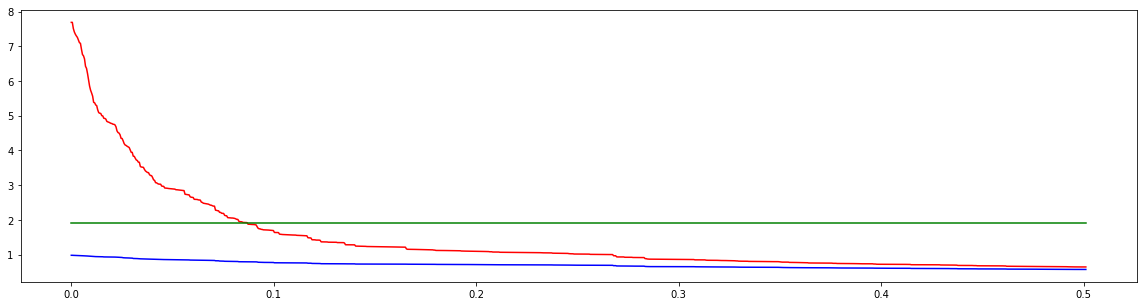

In [192]:
fixed_count = 1.9

s_tp = scores['f0']
s_lc = scores['f1']
s_t = np.full(len(scores['f0']), fixed_count)

plot(alphas, s_tp, '-b', label='Score true positive');
plot(alphas, s_lc, '-r', label='Score label count');
plot(alphas, s_t, '-g', label='Label count limit');

### Скопируем значение первого элемента при пороге 0 из второго элемента. Тогда мы хотя бы сможем посмотреть на график)

А еще разделим количество юзерагентов на **8**, а то 'Score true positive' плохо видно

In [193]:
s_tp[0] = s_tp[1]
s_lc[0] = s_lc[1]

s_lc = s_lc / 8

Max label average: 2
Wanted Score: 0.795161973264
Alpha: 0.08274774774774774


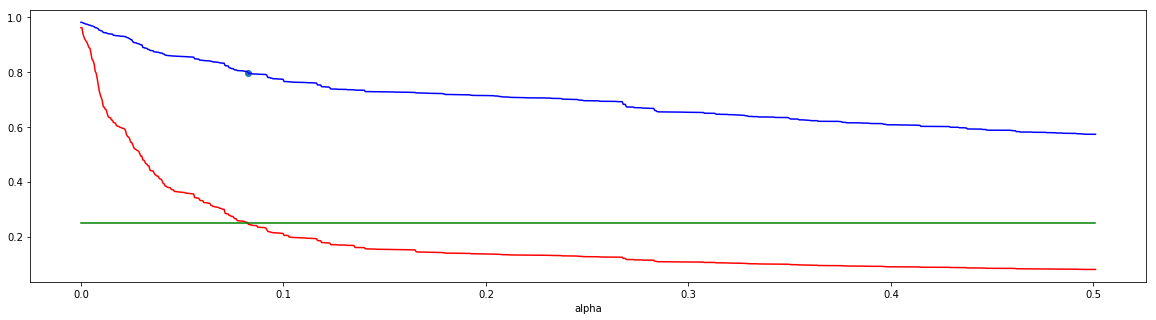

In [201]:
fixed_count = 2

s_t = np.full(len(scores['f0']), fixed_count / 8)

plot(alphas, s_tp, '-b', label='Score true positive');
plot(alphas, s_lc, '-r', label='Score label count');
plot(alphas, s_t, '-g', label='Label count limit');

wanted_score = np.max(scores[scores['f1'] < fixed_count]['f0'])

scatter(alphas[np.argwhere(scores['f0'] == wanted_score)], wanted_score);
xlabel('alpha')

alpha = float(alphas[np.argwhere(scores['f0'] == wanted_score)])

print("Max label average: " + str(fixed_count))
print("Wanted Score: " + str(wanted_score))
print("Alpha: " + str(alpha))

Max label average: 3
Wanted Score: 0.858648014033
Alpha: 0.04463363363363363


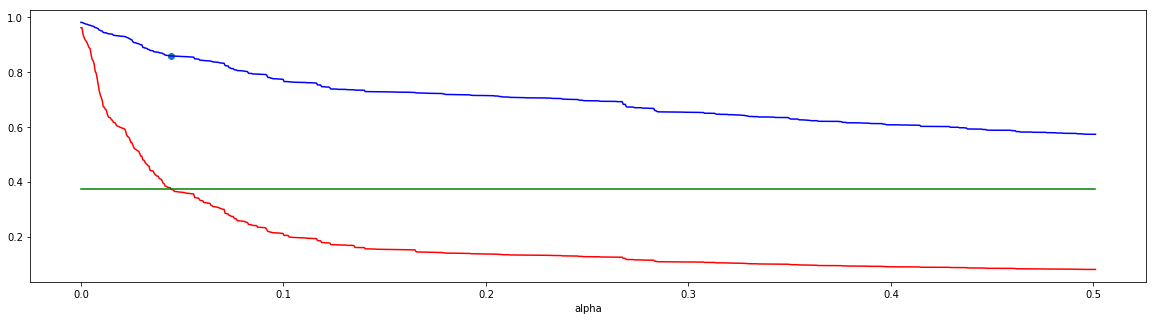

In [219]:
fixed_count = 3

s_t = np.full(len(scores['f0']), fixed_count / 8)

plot(alphas, s_tp, '-b', label='Score true positive');
plot(alphas, s_lc, '-r', label='Score label count');
plot(alphas, s_t, '-g', label='Label count limit');

wanted_score = np.max(scores[scores['f1'] < fixed_count]['f0'])

scatter(alphas[np.argwhere(scores['f0'] == wanted_score)], wanted_score);
xlabel('alpha')

alpha = float(alphas[np.argwhere(scores['f0'] == wanted_score)])

print("Max label average: " + str(fixed_count))
print("Wanted Score: " + str(wanted_score))
print("Alpha: " + str(alpha))

Max label average: 4.5
Wanted Score: 0.92117722751
Alpha: 0.02407207207207207


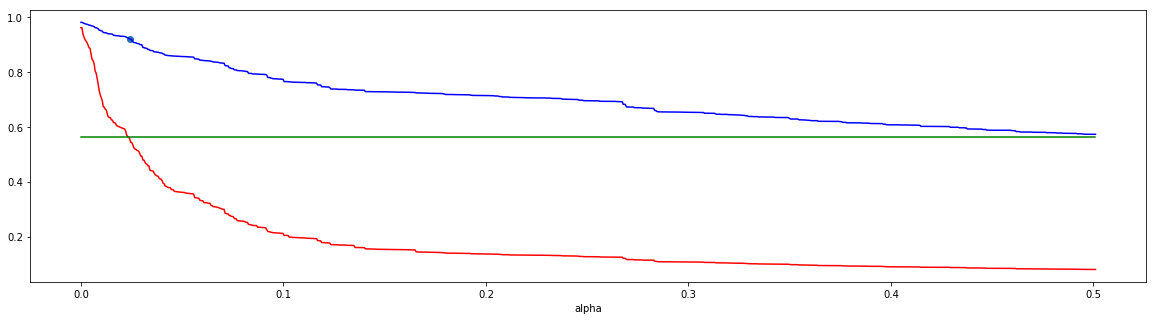

In [207]:
fixed_count = 4.5

s_t = np.full(len(scores['f0']), fixed_count / 8)

plot(alphas, s_tp, '-b', label='Score true positive');
plot(alphas, s_lc, '-r', label='Score label count');
plot(alphas, s_t, '-g', label='Label count limit');

wanted_score = np.max(scores[scores['f1'] < fixed_count]['f0'])

scatter(alphas[np.argwhere(scores['f0'] == wanted_score)], wanted_score);
xlabel('alpha')

alpha = float(alphas[np.argwhere(scores['f0'] == wanted_score)])

print("Max label average: " + str(fixed_count))
print("Wanted Score: " + str(wanted_score))
print("Alpha: " + str(alpha))

In [208]:
%%time
smart_clf = OneVsRestClassifier(LogisticRegression(random_state=42, C=100))
smart_clf.fit(X_train, y_train)
answer = smart_clf.predict(X_test)

CPU times: user 23min 51s, sys: 40.2 s, total: 24min 31s
Wall time: 9min 50s


In [220]:
def smart_prediction(pred, clf, X_test, y_test, alpha):
    """
    :param clf: Classifyer
    :param X_test: X test sample
    :param y_test: y test sample
    :param alpha: Threshold
    :return: list of list true User Agent names from test sample, list of list Predicted User Agent, list of bool true if at least one predicted User Agent equal true User Agent, list of answer count
    """
    predictions_proba = clf.predict_proba(X_test)

    y_test_names = pd.DataFrame(y_test).apply(
        lambda l: pred.return_prediction_ua(l), axis=1)
    y_predicted = pd.DataFrame(predictions_proba).apply(
        lambda l: pred.return_thresolded_prediction_ua(l, alpha), axis=1)

    compare_answers = []
    answers_count = []
    for i, y_tst in enumerate(y_test_names):
        current_answer = True
        if y_tst not in y_predicted[i]:
            current_answer = False
        compare_answers.append(current_answer)
        answers_count.append(len(y_predicted[i]))

    return y_test_names, y_predicted, compare_answers, answers_count

In [221]:
y_test_names, y_predicted, compare_answers, answers_count = smart_prediction(pred, smart_clf, X_test, y_test, alpha)

In [222]:
compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

print("Answers Count Median = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

Answers Count Median = 3.2234756961223776
True Positive = 0.9119494759294129


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[netEstate NE Crawler (+http://www.website-dat...,True,1
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,9
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,9
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


In [223]:
y_test_names, y_predicted, compare_answers, answers_count = smart_prediction(pred, smart_clf, X_test, y_test, 0.02407207207207207)

compare_frame = pd.concat(
    [
        y_test_names,
        y_predicted, 
        pd.DataFrame(compare_answers), 
        pd.DataFrame(answers_count)
    ], keys=['test', 'predicted', 'correctness', 'count'], axis=1, join='inner')

print("Answers Count Median = {0}".format(np.average(answers_count)))
smart_accuracy = numpy.sum(compare_answers) / y_test.shape[0]
print("True Positive = {0}".format(smart_accuracy))
compare_frame

Answers Count Median = 4.450317441802336
True Positive = 0.9537918048357801


,test,predicted,correctness,count
,0,1,0,0
0,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True,1
1,netEstate NE Crawler (+http://www.website-date...,[netEstate NE Crawler (+http://www.website-dat...,True,1
2,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
3,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True,1
4,Mozilla/5.0 (compatible; Yahoo! Slurp; http://...,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,True,14
...,...,...,...,...
60006,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True,1
60007,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1
60008,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True,1


### До меня дошло что количество лейблов это tp + fp

Знвчит можно считать precision и затачивать на него кстати.

Ведь

$$
precision = \frac{tp}{tp+fp}\
$$

In [230]:
from sklearn.metrics import precision_score

def p_score(alpha, y, y_hat_dummy):
    return precision_score(y, (y_hat_dummy > alpha).astype('int'), average='samples')

In [231]:
p_s = [p_score(alpha, y, y_hat_dummy) for alpha in alphas]

Max label average: 4.5
Wanted Score: 0.92117722751
Alpha: 0.02407207207207207


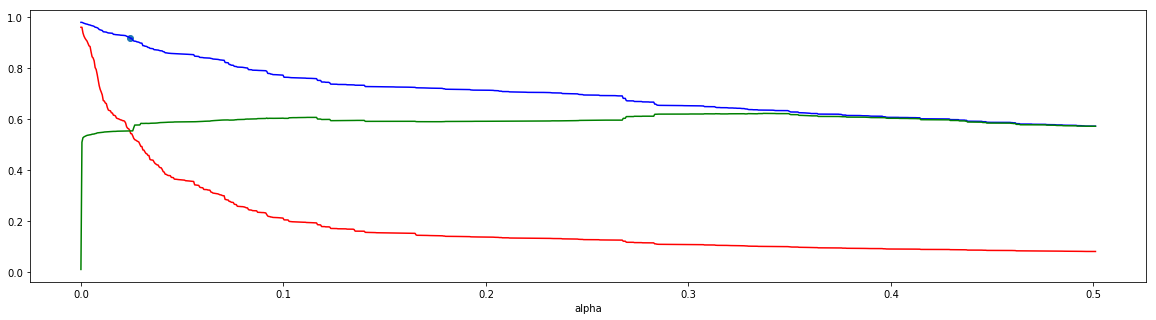

In [232]:
fixed_count = 4.5

s_t = np.full(len(scores['f0']), fixed_count / 8)

plot(alphas, s_tp, '-b', label='Score true positive');
plot(alphas, s_lc, '-r', label='Score label count');
plot(alphas, p_s, '-g', label='Precision');

wanted_score = np.max(scores[scores['f1'] < fixed_count]['f0'])

scatter(alphas[np.argwhere(scores['f0'] == wanted_score)], wanted_score);
xlabel('alpha')

alpha = float(alphas[np.argwhere(scores['f0'] == wanted_score)])

print("Max label average: " + str(fixed_count))
print("Wanted Score: " + str(wanted_score))
print("Alpha: " + str(alpha))